# Start Pooling

In [1]:
#import general packages
import numpy as np
import dill
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

#import climada stuff
from climada.entity.impact_funcs import trop_cyclone, impact_func_set
from climada.util.api_client import Client
from climada.engine import ImpactCalc

%load_ext autoreload
%autoreload 2
import exposures as ex
import grider as grd
import impact as cimp
import bound_prot_dam as bpd
import prem_ibrd as prib
import haz_int_grd as hig
import set_nominal as snom
import calc_premium as cp
import simulate_bond as sb
import alt_pay_opt as apo
import simulate_multi_cty_bond as smcb
client = Client()

c:\Users\kaibe\miniforge3\envs\climada_env\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


## Define Countries and Variables for Cat Bond Development

In [2]:
#choose storm basin to load
#The STORM basins are: 'EP','NA','NI','SI','SP','WP'
#basins = ['NA','SI']

#choose country
country_1 = 174
country_2 = 659
countries = [str(country_1), str(country_2)]

#minimum damage to be protected per grid cell calculated using return period
lower_rp = 100

#number of simulated years
r = 10000
#number of Monte-Carlo simulations
num_simulations = 20000


#set risk free rate, either single value or array
rf_rates = 0.01

#specify if we want average annual returns (True) or compounded annual returns (False)
ann_com = True

#set range of premiums 
premiums = np.arange(0.00, 0.26, 0.01) 
#inititate IBRD premium calculation function
params_ibrd = prib.init_prem_ibrd(want_plot=False)
a, k, b = params_ibrd
#set risk muliplier reported by artems
artemis_multiplier = 4.11

#set sharpe ratio to beat
requ_sharpe_ratio = 0.5

#set the maximum amount to be protected
prot_share_arr = np.arange(0.01, 0.21, 0.01) #protected share of total exposure

## Designe Single Country Bonds
### Define Cat Bond function

In [7]:
def init_sng_cty_bond(country, prot_share, incl_plots=False):    
    #load tc_tracks, create hazard class and calculate exposure
    exp, applicable_basins, storm_basin_sub, tc_storms = ex.init_TC_exp(country=country, load_fls=True, plot_exp=incl_plots)
    #set up grid for cat bond
    rst_grid = grd.init_grid(exp, plot_rst=incl_plots)
    #calculate impact and aggregate impact per grid
    imp, imp_per_exp, agg_exp, imp_grid_evt = cimp.init_imp(exp, tc_storms, rst_grid, plot_frequ=incl_plots) 
    #set up hazard intensity matrix per grid and event
    ws_grid = hig.init_ws_grid(tc_storms, agg_exp, 100)
    #calculate damage return period and set small damages, not intended to protect to zero
    rp_dam_grid, dam_rp_per_grid, imp_grid_evt_flt = bpd.init_dam_ret_per_grid(imp_grid_evt, lower_rp, adj_max=False, plt_dam_rp_grid=None)
    #set principal
    premium_dic = {}
    for ps_share in prot_share:
        ps_str = str(ps_share)
        premium_dic[ps_str] = {'ibrd': 0, 'artemis': 0, 'regression': 0, 'required': 0, 'exp_loss': 0, 'att_prob': 0}

    premium_simulation_ps = {}
    returns_ps = {}
    pay_dam_df_ps = {}
    es_metrics_ps = {}

    nom_arr = []
    for i in range(len(prot_share)):
        ps_str = str(prot_share[i])
        nominal, tot_exp, nom_rel_exp = snom.init_nominal(impact=imp, exposure=exp, prot_share=prot_share[i])
        nom_arr.append(nominal)
        #optimize minimum and maximum triggering wind speed per grid cell
        result, optimized_xs, optimized_ys = apo.init_alt_optimization(ws_grid, imp_grid_evt_flt, nominal)
        #create data frame containing payment vs damage per event
        pay_dam_df = apo.alt_pay_vs_damage(imp_grid_evt_flt, optimized_xs, optimized_ys, ws_grid, nominal, include_plot=False)
        #calculate expected loss and attachment probability
        exp_loss_ann, att_prob, es_metrics = sb.init_exp_loss_att_prob_simulation(pay_dam_df, nominal)
        #calculate premiums using different approaches
        premium_dic[ps_str]['ibrd'] = prib.monoExp(exp_loss_ann*100, a, k, b) * exp_loss_ann
        premium_dic[ps_str]['artemis'] = exp_loss_ann * artemis_multiplier
        premium_dic[ps_str]['regression'] = cp.calc_premium_regression(exp_loss_ann *100)/100

    #print(f'The premium based on past IBRD bonds is {round(premium_ibrd*100, 3)}%')
    #print(f'The premium based on the artemis multiplier is {round(premium_artemis*100, 3)}%')
    #print(f'The premium based on the regression model from Chatoro et al. 2022 is {round(premium_regression*100, 3)}%')

        #simulate cat bond
        premium_simulation, returns = sb.init_bond_simulation(pay_dam_df, premiums, rf_rates, nominal, ann_com) #simulate cat bond using a Monte Carlo simulation
        #determine premium to match required sharp ratio
        requ_premiums = sb.init_requ_premium(requ_sharpe_ratio, premium_simulation, rf_rates) #calculate required premium to match minimum sharpe ratio
        #sb.display_premiums([requ_premiums], [requ_sharpe_ratio], rf_rates, premium_simulation, exp_loss_ann)   #plot premium versus sharpe ratio
        premium_dic[ps_str]['required'] = requ_premiums
        premium_dic[ps_str]['exp_loss'] = exp_loss_ann
        premium_dic[ps_str]['att_prob'] = att_prob
        premium_simulation_ps[ps_str] = premium_simulation
        returns_ps[ps_str] = returns
        pay_dam_df_ps[ps_str] = pay_dam_df
        es_metrics_ps[ps_str] = es_metrics

    return premium_simulation_ps, returns_ps, premium_dic, nom_arr, pay_dam_df_ps, es_metrics_ps, ws_grid, imp_grid_evt_flt

### Design Cat Bond for Country 1

In [11]:
premium_simulation_662, returns_662, premium_dic_662, nominal_662, pay_dam_df_662, es_metrics_662, ws_grid_662, imp_grid_evt_flt_662 = init_sng_cty_bond(country_2, prot_share_arr)

STORM basin of country:  NA
----------------------Loading Exposure----------------------
----------------------Loading Hazard----------------------
The principal of the cat bond is: 8839222.222222218
Principal as perecntage of GDP: 0.010000000000000002
{0: (20.0, 51.0), 1: (20.0, 109.24445922644648), 2: (20.0, 51.0)}
Expected Loss = 0.05924791557766253
Attachment Probability = 0.07308859324464004
Intersection point using risk free interest rate of 1.0%: Premium = 0.1631, Sharpe Ratio = 0.5000
The principal of the cat bond is: 17678444.444444437
Principal as perecntage of GDP: 0.020000000000000004
{0: (20.0, 51.0), 1: (20.0, 171.4097771584039), 2: (20.0, 54.045170996613116)}
Expected Loss = 0.05733433107689786
Attachment Probability = 0.07318862325364275
Intersection point using risk free interest rate of 1.0%: Premium = 0.1569, Sharpe Ratio = 0.5000
The principal of the cat bond is: 26517666.66666665
Principal as perecntage of GDP: 0.029999999999999995
{0: (20.0, 51.0), 1: (20.0, 212.1

### Design Cat Bond for Country 2

In [9]:
premium_simulation_174, returns_174, premium_dic_174, nominal_174, pay_dam_df_174, es_metrics_174, ws_grid_172, imp_grid_evt_flt_172 = init_sng_cty_bond(country_1, prot_share_arr)

STORM basin of country:  SI
----------------------Loading Exposure----------------------
----------------------Loading Hazard----------------------
The principal of the cat bond is: 12250391.966109099
Principal as perecntage of GDP: 0.01
{0: (20.0, 51.0), 1: (20.0, 51.0), 2: (20.0, 51.0), 3: (40.0, 250.0), 4: (20.00037544162488, 52.682847902558215), 5: (20.0, 51.0), 6: (20.0, 245.20476818312775), 7: (40.0, 250.0), 8: (20.000020811003225, 68.46574509402951), 9: (40.0, 250.0)}
Expected Loss = 0.016577838545217435
Attachment Probability = 0.01963922510086359
Intersection point using risk free interest rate of 1.0%: Premium = 0.0588, Sharpe Ratio = 0.5000
The principal of the cat bond is: 24500783.932218198
Principal as perecntage of GDP: 0.02
{0: (20.0, 51.0), 1: (20.53587016151394, 73.22283480461859), 2: (20.0, 57.205391309605204), 3: (40.0, 250.0), 4: (21.14337249902398, 78.11405686521638), 5: (20.0, 51.0), 6: (23.02343949746719, 250.0), 7: (40.0, 250.0), 8: (40.0, 250.0), 9: (40.0, 250

c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\simulate_bond.py:206: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  x_intersection = fsolve(intersection_func, x_guess)[0]


Intersection point using risk free interest rate of 1.0%: Premium = 0.0339, Sharpe Ratio = 0.5000
The principal of the cat bond is: 134754311.6272001
Principal as perecntage of GDP: 0.11
{0: (20.066560986849815, 61.61221464187557), 1: (20.000445996036632, 191.25689804694494), 2: (40.0, 250.0), 3: (40.0, 250.0), 4: (20.0, 198.06162901684084), 5: (20.00004257692334, 124.46867398736154), 6: (28.98198620560715, 250.0), 7: (40.0, 250.0), 8: (40.0, 250.0), 9: (40.0, 250.0)}
Expected Loss = 0.007937215068761026
Attachment Probability = 0.014904471341402421


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\simulate_bond.py:206: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  x_intersection = fsolve(intersection_func, x_guess)[0]


Intersection point using risk free interest rate of 1.0%: Premium = 0.0319, Sharpe Ratio = 0.5000
The principal of the cat bond is: 147004703.5933092
Principal as perecntage of GDP: 0.12
{0: (20.445377488351966, 64.05408312278077), 1: (20.00309275042661, 195.15986315108862), 2: (40.0, 250.0), 3: (40.0, 250.0), 4: (20.0, 206.88634934087042), 5: (20.000041740529543, 130.12395091989083), 6: (30.121650823575422, 250.0), 7: (40.0, 250.0), 8: (40.0, 250.0), 9: (40.0, 250.0)}
Expected Loss = 0.00738766410939567
Attachment Probability = 0.014204261278383515
Intersection point using risk free interest rate of 1.0%: Premium = 0.0301, Sharpe Ratio = 0.5000
The principal of the cat bond is: 159255095.5594183
Principal as perecntage of GDP: 0.13
{0: (20.000000001062432, 68.68709392001722), 1: (20.0, 199.45104971488922), 2: (40.0, 250.0), 3: (40.0, 250.0), 4: (20.0, 211.2896486484238), 5: (20.000000056717386, 135.45830981947688), 6: (30.121367536903502, 250.0), 7: (40.0, 250.0), 8: (40.0, 250.0), 9:

## Designe Multi-Country Bond
### Set Variables for Multi-Country Bond

In [10]:
nominal_pool = [e1 + e2 for e1, e2 in zip(nominal_174, nominal_662)]


NameError: name 'nominal_662' is not defined

### Create Multi-Country bond

In [7]:
exp_loss_pool = {}
att_prob_pool = {}
es_metrics = {}
MES_cty = {}
metrics_pool = {}
returns_pool = {}
tot_coverage_pool_cty = {}
requ_premiums = {}

for i in range(len(prot_share_arr)):
    ps_str = str(prot_share_arr[i])
    nominal = nominal_pool[i]
    pay_dam_df_dic = {country_1: pay_dam_df_174[ps_str],
                      country_2: pay_dam_df_662[ps_str]}
    exp_loss_pool[ps_str], att_prob_pool[ps_str], es_metrics[ps_str], MES_cty[ps_str] = smcb.init_exp_loss_att_prob_simulation(pay_dam_df_dic, nominal)
    metrics_pool[ps_str], returns_pool[ps_str], tot_coverage_pool_cty[ps_str] = smcb.init_bond_simulation(pay_dam_df_dic, premiums, rf_rates, nominal, countries, ann_com)

    requ_premiums[ps_str] = sb.init_requ_premium(requ_sharpe_ratio, metrics_pool[ps_str], rf_rates) #calculate required premium to match minimum sharpe ratio
    #sb.display_premiums([requ_premiums[ps_str]], [requ_sharpe_ratio], rf_rates, metrics_pool[ps_str], exp_loss_pool[ps_str])   #plot premium versus sharpe ratio

Expected Loss = 0.036220154900365745
Attachment Probability = 0.09343333333333331
Intersection point using risk free interest rate of 1.0%: Premium = 0.1162, Sharpe Ratio = 0.5000
Expected Loss = 0.03444091514490495
Attachment Probability = 0.09403333333333333
Intersection point using risk free interest rate of 1.0%: Premium = 0.1079, Sharpe Ratio = 0.5000
Expected Loss = 0.03286000167469499
Attachment Probability = 0.09276666666666665
Intersection point using risk free interest rate of 1.0%: Premium = 0.1060, Sharpe Ratio = 0.5000
Expected Loss = 0.030809493220103647
Attachment Probability = 0.0937
Intersection point using risk free interest rate of 1.0%: Premium = 0.0954, Sharpe Ratio = 0.5000
Expected Loss = 0.027145611406812067
Attachment Probability = 0.08933333333333332
Intersection point using risk free interest rate of 1.0%: Premium = 0.0873, Sharpe Ratio = 0.5000
Expected Loss = 0.023416715147388984
Attachment Probability = 0.0846
Intersection point using risk free interest ra

c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\simulate_bond.py:205: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  x_intersection = fsolve(intersection_func, x_guess)[0]


Intersection point using risk free interest rate of 1.0%: Premium = 0.0715, Sharpe Ratio = 0.5000
Expected Loss = 0.01935733644928236
Attachment Probability = 0.0807


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\simulate_bond.py:205: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  x_intersection = fsolve(intersection_func, x_guess)[0]


Intersection point using risk free interest rate of 1.0%: Premium = 0.0657, Sharpe Ratio = 0.5000
Expected Loss = 0.017999866048411233
Attachment Probability = 0.08036666666666667
Intersection point using risk free interest rate of 1.0%: Premium = 0.0598, Sharpe Ratio = 0.5000
Expected Loss = 0.015957985419288324
Attachment Probability = 0.07359999999999998
Intersection point using risk free interest rate of 1.0%: Premium = 0.0568, Sharpe Ratio = 0.5000
Expected Loss = 0.01565940508874711
Attachment Probability = 0.0775
Intersection point using risk free interest rate of 1.0%: Premium = 0.0520, Sharpe Ratio = 0.5000
Expected Loss = 0.013699044380977665
Attachment Probability = 0.07186666666666665
Intersection point using risk free interest rate of 1.0%: Premium = 0.0500, Sharpe Ratio = 0.5000
Expected Loss = 0.012586652626906432
Attachment Probability = 0.0692
Intersection point using risk free interest rate of 1.0%: Premium = 0.0446, Sharpe Ratio = 0.5000
Expected Loss = 0.01213325084

c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\simulate_bond.py:205: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  x_intersection = fsolve(intersection_func, x_guess)[0]


Intersection point using risk free interest rate of 1.0%: Premium = 0.0402, Sharpe Ratio = 0.5000
Expected Loss = 0.01059503799520946
Attachment Probability = 0.06603333333333332
Intersection point using risk free interest rate of 1.0%: Premium = 0.0363, Sharpe Ratio = 0.5000
Expected Loss = 0.009751458615440097
Attachment Probability = 0.0633
Intersection point using risk free interest rate of 1.0%: Premium = 0.0354, Sharpe Ratio = 0.5000
Expected Loss = 0.009680741053276508
Attachment Probability = 0.062266666666666665
Intersection point using risk free interest rate of 1.0%: Premium = 0.0344, Sharpe Ratio = 0.5000
Expected Loss = 0.008597590407093517
Attachment Probability = 0.059966666666666654
Intersection point using risk free interest rate of 1.0%: Premium = 0.0328, Sharpe Ratio = 0.5000
Expected Loss = 0.008677588777500786
Attachment Probability = 0.06
Intersection point using risk free interest rate of 1.0%: Premium = 0.0300, Sharpe Ratio = 0.5000


## Analyze Multi-Country vs. Single-Country Bonds

### Premiums

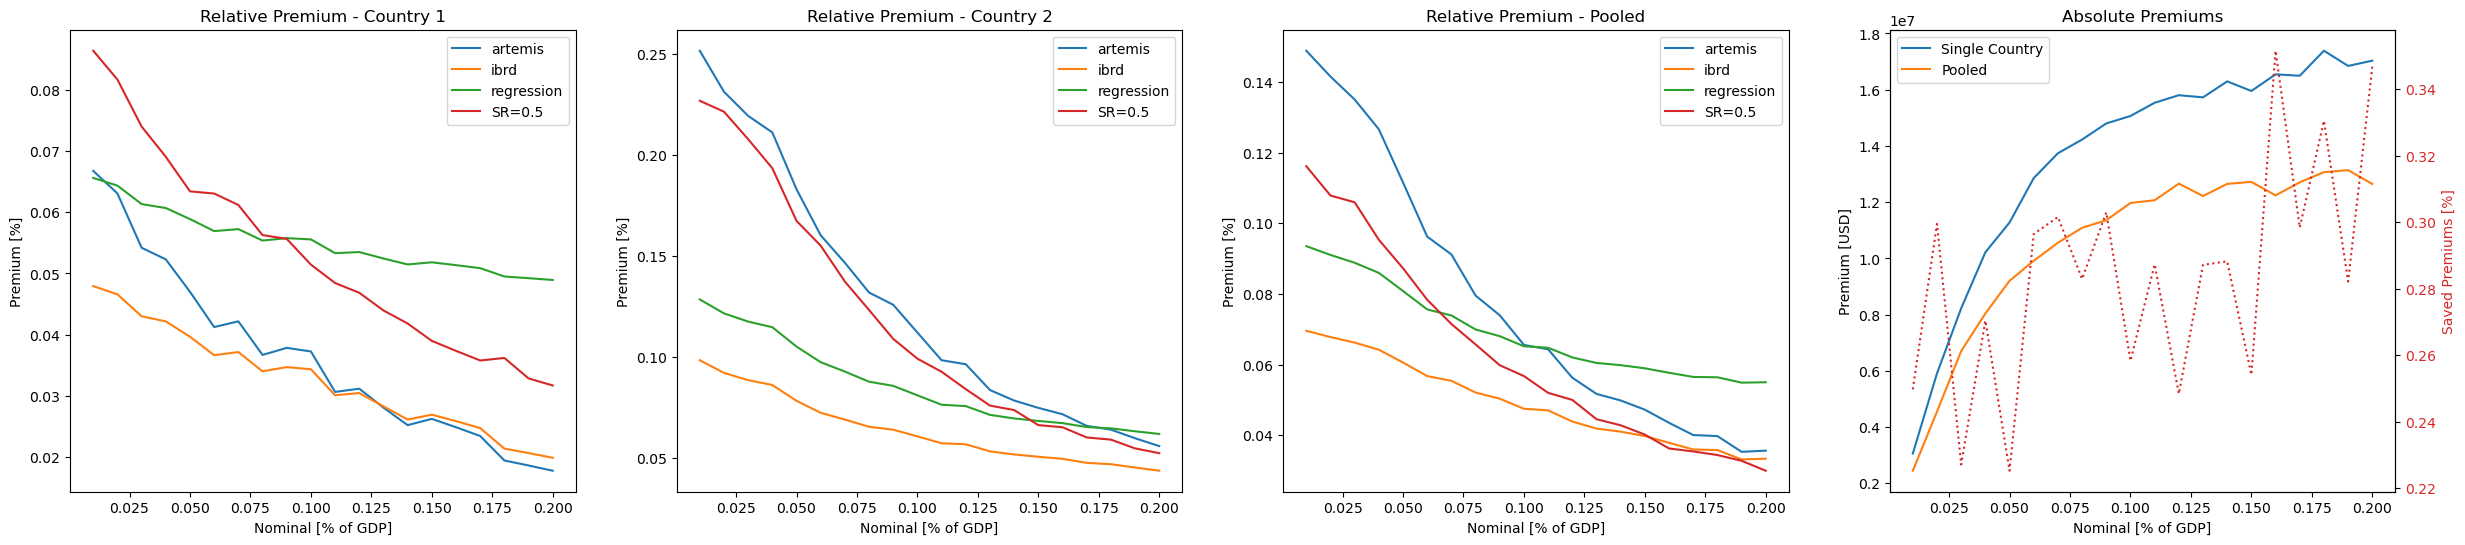

In [8]:
artemis_arr_174 = []
ibrd_arr_174 = []
regression_arr_174 = []
required_arr_174 = []
artemis_arr_662 = []
ibrd_arr_662 = []
regression_arr_662 = []
required_arr_662 = []
requ_prem_pool = []
ibrd_pool = []
artemis_pool = []
regression_pool = []
exp_loss_174 = []
exp_loss_662 = []
exp_loss_pool_arr = []

for ps_share in prot_share_arr:
    ps_str = str(ps_share)

    artemis_arr_174.append(premium_dic_174[ps_str]['artemis'])
    ibrd_arr_174.append(premium_dic_174[ps_str]['ibrd'])
    regression_arr_174.append(premium_dic_174[ps_str]['regression'])
    required_arr_174.append(premium_dic_174[ps_str]['required'])

    artemis_arr_662.append(premium_dic_662[ps_str]['artemis'])
    ibrd_arr_662.append(premium_dic_662[ps_str]['ibrd'])
    regression_arr_662.append(premium_dic_662[ps_str]['regression'])
    required_arr_662.append(premium_dic_662[ps_str]['required'])

    requ_prem_pool.append(requ_premiums[ps_str])
    ibrd_pool.append(prib.monoExp(exp_loss_pool[ps_str]*100, a, k, b) * exp_loss_pool[ps_str])
    artemis_pool.append(exp_loss_pool[ps_str] * artemis_multiplier)
    regression_pool.append(cp.calc_premium_regression(exp_loss_pool[ps_str] *100)/100)

    exp_loss_174.append(premium_dic_174[ps_str]['exp_loss'])
    exp_loss_662.append(premium_dic_662[ps_str]['exp_loss'])
    exp_loss_pool_arr.append(exp_loss_pool[ps_str])


abs_prem_174  = [e1 * e2 for e1, e2 in zip(required_arr_174, nominal_174)]
abs_prem_662  = [e1 * e2 for e1, e2 in zip(required_arr_662, nominal_662)]
abs_prem_sng  = [e1 + e2 for e1, e2 in zip(abs_prem_174, abs_prem_662)]
abs_prem_pool  = [e1 * e2 for e1, e2 in zip(requ_prem_pool, nominal_pool)]
diff_prem  = [(e1 - e2) / e2 for e1, e2 in zip(abs_prem_sng, abs_prem_pool)]



fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 6))

ax1.plot(prot_share_arr, artemis_arr_174, label='artemis')
ax1.plot(prot_share_arr, ibrd_arr_174, label='ibrd')
ax1.plot(prot_share_arr, regression_arr_174, label='regression')
ax1.plot(prot_share_arr, required_arr_174, label=f'SR={requ_sharpe_ratio}')
ax1.set_xlabel('Nominal [% of GDP]')
ax1.set_ylabel('Premium [%]')
ax1.set_title('Relative Premium - Country 1')
ax1.legend()

ax2.plot(prot_share_arr, artemis_arr_662, label='artemis')
ax2.plot(prot_share_arr, ibrd_arr_662, label='ibrd')
ax2.plot(prot_share_arr, regression_arr_662, label='regression')
ax2.plot(prot_share_arr, required_arr_662, label=f'SR={requ_sharpe_ratio}')
ax2.set_xlabel('Nominal [% of GDP]')
ax2.set_ylabel('Premium [%]')
ax2.set_title('Relative Premium - Country 2')
ax2.legend()

ax3.plot(prot_share_arr, artemis_pool, label='artemis')
ax3.plot(prot_share_arr, ibrd_pool, label='ibrd')
ax3.plot(prot_share_arr, regression_pool, label='regression')
ax3.plot(prot_share_arr, requ_prem_pool, label=f'SR={requ_sharpe_ratio}')
ax3.set_xlabel('Nominal [% of GDP]')
ax3.set_ylabel('Premium [%]')
ax3.set_title('Relative Premium - Pooled')
ax3.legend()

ax4.plot(prot_share_arr, abs_prem_sng, label='Single Country')
ax4.plot(prot_share_arr, abs_prem_pool, label='Pooled')
ax4.set_xlabel('Nominal [% of GDP]')
ax4.set_ylabel('Premium [USD]')
ax4.set_title('Absolute Premiums')
ax4.legend()

color='tab:red'
ax5 = ax4.twinx()  # instantiate a second Axes that shares the same x-axis
ax5.set_ylabel('Saved Premiums [%]', color=color)  # we already handled the x-label with ax1
ax5.plot(prot_share_arr, diff_prem, linestyle='dotted', label='Saved premiumds', color=color)
ax5.tick_params(axis='y', labelcolor=color)

plt.show()

### Coverage

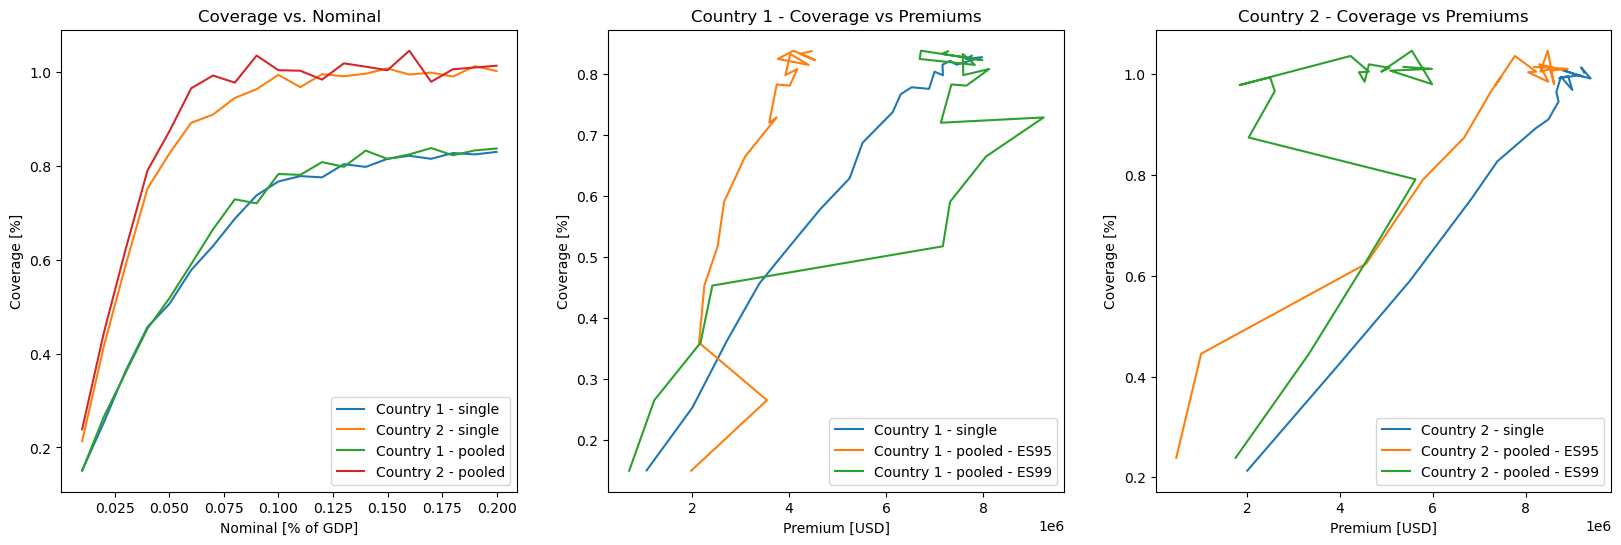

In [9]:
cov_174 = []
cov_662 = []
cov_pool_174 = []
cov_pool_662 = []
abs_prem_pool_99_174 = []
abs_prem_pool_99_662 = []
abs_prem_pool_95_174 = []
abs_prem_pool_95_662 = []


for i in range(len(prot_share_arr)):
    ps_str = str(prot_share_arr[i])

    cov_174.append(np.mean(premium_simulation_174[ps_str]['Coverage']))
    cov_662.append(np.mean(premium_simulation_662[ps_str]['Coverage']))    
    cov_pool_174.append(np.mean(tot_coverage_pool_cty[ps_str]['174']['coverage']))
    cov_pool_662.append(np.mean(tot_coverage_pool_cty[ps_str]['659']['coverage']))

    abs_prem_pool_95_174.append(MES_cty[ps_str][0]['95'] / es_metrics[ps_str]['ES_95_ann'] * requ_premiums[ps_str] * nominal_pool[i])
    abs_prem_pool_95_662.append(MES_cty[ps_str][1]['95'] / es_metrics[ps_str]['ES_95_ann'] * requ_premiums[ps_str] * nominal_pool[i])
    abs_prem_pool_99_174.append(MES_cty[ps_str][0]['99'] / es_metrics[ps_str]['ES_99_ann'] * requ_premiums[ps_str] * nominal_pool[i])
    abs_prem_pool_99_662.append(MES_cty[ps_str][1]['99'] / es_metrics[ps_str]['ES_99_ann'] * requ_premiums[ps_str] * nominal_pool[i])


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.plot(prot_share_arr, cov_174, label='Country 1 - single')
ax1.plot(prot_share_arr, cov_662, label='Country 2 - single')
ax1.plot(prot_share_arr, cov_pool_174, label='Country 1 - pooled')
ax1.plot(prot_share_arr, cov_pool_662, label='Country 2 - pooled')
ax1.set_xlabel('Nominal [% of GDP]')
ax1.set_ylabel('Coverage [%]')
ax1.set_title('Coverage vs. Nominal')
ax1.legend()

ax2.plot(abs_prem_174, cov_174, label='Country 1 - single')
ax2.plot(abs_prem_pool_95_174, cov_pool_174, label='Country 1 - pooled - ES95')
ax2.plot(abs_prem_pool_99_174, cov_pool_174, label='Country 1 - pooled - ES99')
ax2.set_xlabel('Premium [USD]')
ax2.set_ylabel('Coverage [%]')
ax2.set_title('Country 1 - Coverage vs Premiums')
ax2.legend()

ax3.plot(abs_prem_662, cov_662, label='Country 2 - single')
ax3.plot(abs_prem_pool_95_662, cov_pool_662, label='Country 2 - pooled - ES95')
ax3.plot(abs_prem_pool_99_662, cov_pool_662, label='Country 2 - pooled - ES99')
ax3.set_xlabel('Premium [USD]')
ax3.set_ylabel('Coverage [%]')
ax3.set_title('Country 2 - Coverage vs Premiums')
ax3.legend()

plt.show()

### Performance

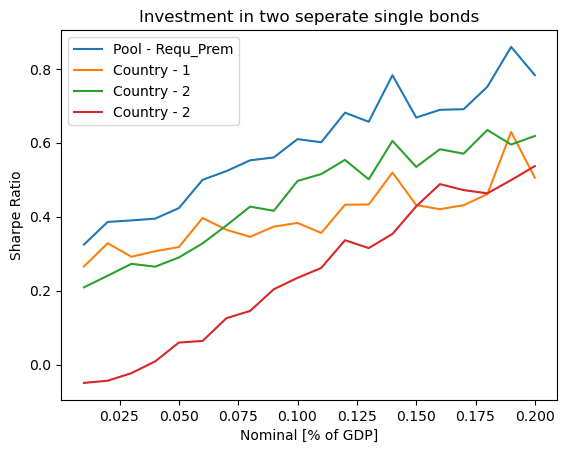

In [28]:
shp_rat_requ_prem_prot = []
shp_rat__ibrd_premprot = []
shp_rat_174 = []
shp_rat_662 = []
requ_prem_returns_pool = {}

for i in range(len(prot_share_arr)):
    ps_str = str(prot_share_arr[i])
    ps_requ_prem_174, ret_requ_prem_174 = sb.init_bond_simulation(pay_dam_df_174[ps_str], required_arr_174[i], rf_rates, event_probability_174, nominal_174[i], ann_com) #simulate cat bond using a Monte Carlo simulation
    ps_requ_prem_662, ret_requ_prem_662 = sb.init_bond_simulation(pay_dam_df_662[ps_str], required_arr_662[i], rf_rates, event_probability_662, nominal_662[i], ann_com) #simulate cat bond using a Monte Carlo simulation
    ps_ibrd_prem_174, ret_ibrd_prem_174 = sb.init_bond_simulation(pay_dam_df_174[ps_str], ibrd_arr_174[i], rf_rates, event_probability_174, nominal_174[i], ann_com) #simulate cat bond using a Monte Carlo simulation
    ps_ibrd_prem_662, ret_ibrd_prem_662 = sb.init_bond_simulation(pay_dam_df_662[ps_str], ibrd_arr_662[i], rf_rates, event_probability_662, nominal_662[i], ann_com) #simulate cat bond using a Monte Carlo simulation
    ann_returns_requ_prem_sng = ((ret_requ_prem_174['Annual'][0] * nominal_174[i]) + (ret_requ_prem_662['Annual'][0] * nominal_662[i])) / (nominal_174[i] + nominal_662[i])
    ann_returns_ibrd_prem_sng = ((ret_ibrd_prem_174['Annual'][0] * nominal_174[i]) + (ret_ibrd_prem_662['Annual'][0] * nominal_662[i])) / (nominal_174[i] + nominal_662[i])
    shp_rat_requ_prem_prot.append(sb.init_sharpe_ratio(ann_returns_requ_prem_sng, rf_rates))
    shp_rat__ibrd_premprot.append(sb.init_sharpe_ratio(ann_returns_ibrd_prem_sng, rf_rates))
    shp_rat_174.append(sb.init_sharpe_ratio(ret_requ_prem_174['Annual'][0], rf_rates))
    shp_rat_662.append(sb.init_sharpe_ratio(ret_requ_prem_662['Annual'][0], rf_rates))

    pay_dam_df_dic = {country_1: pay_dam_df_174[ps_str],
                      country_2: pay_dam_df_662[ps_str]}
    requ_prem_metrics_pool, requ_prem_returns_pool[ps_str], requ_prem_tot_coverage_pool_cty = smcb.init_bond_simulation(pay_dam_df_dic, requ_prem_pool[i], rf_rates, event_probabilities, nominal_pool[i], countries, ann_com)



plt.plot(prot_share_arr, shp_rat_requ_prem_prot, label='Pool - Requ Prem')
plt.plot(prot_share_arr, shp_rat_174, label='Country - 1')
plt.plot(prot_share_arr, shp_rat_662, label='Country - 2')
plt.plot(prot_share_arr, shp_rat__ibrd_premprot, label='Pool - IBRD Prem')
plt.xlabel('Nominal [% of GDP]')
plt.ylabel('Sharpe Ratio')
plt.title('Investment in two seperate single bonds')
plt.legend()
plt.show()

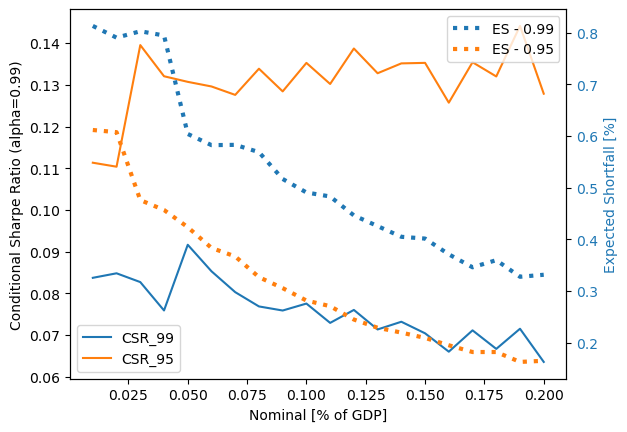

In [27]:
CSR_99 = []
CSR_95 = []
es_99_pool = []
es_95_pool = []

for ps_share in prot_share_arr:
    ps_str = str(ps_share) 
    ES_99_nom = es_metrics[ps_str]['ES_99_ann']
    ES_95_nom = es_metrics[ps_str]['ES_95_ann']

    es_99_pool.append(ES_99_nom)
    es_95_pool.append(ES_95_nom)
    
    CSR_99.append(smcb.init_sharpe_ratio(requ_prem_returns_pool[ps_str]['Annual'][0], rf_rates, ES_99_nom))
    CSR_95.append(smcb.init_sharpe_ratio(requ_prem_returns_pool[ps_str]['Annual'][0], rf_rates, ES_95_nom))

fig, ax1 = plt.subplots()

ax1.plot(prot_share_arr, CSR_99, label='CSR_99')
ax1.plot(prot_share_arr, CSR_95, label='CSR_95')
ax1.set_xlabel('Nominal [% of GDP]')
ax1.set_ylabel('Conditional Sharpe Ratio (alpha=0.99)')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

color = 'tab:blue'
color1 = 'tab:orange'
ax2.set_ylabel('Expected Shortfall [%]', color=color) 
ax2.plot(prot_share_arr, es_99_pool, color=color, linestyle='dotted', linewidth='3.0', label='ES - 0.99')
ax2.plot(prot_share_arr, es_95_pool, color=color1, linestyle='dotted', linewidth='3.0', label='ES - 0.95')

ax2.tick_params(axis='y', labelcolor=color)

ax2.legend()
ax1.legend()
plt.show()

### Cost-Benefit

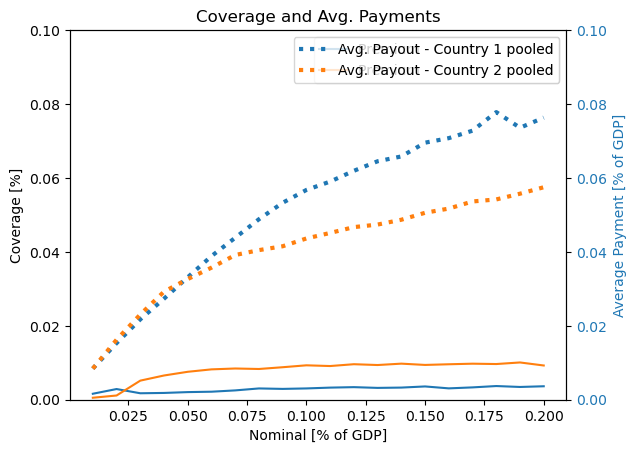

In [26]:
tot_exp_174 = nominal_174[19] / prot_share_arr[19] 
tot_exp_662 = nominal_662[19] / prot_share_arr[19] 


avg_pay_rel_gdp_174 = []
avg_pay_rel_gdp_662 = []
avg_pay_abs_174 = []
avg_pay_abs_662 = []
avg_pay_prot = []


for i in range(len(prot_share_arr)):
    ps_str = str(prot_share_arr[i])
    avg_pay_prot.append(metrics_pool[ps_str]['Average Payments'].mean())
    avg_pay_rel_gdp_174.append(np.sum(tot_coverage_pool_cty[ps_str]['174']['payout']) / (len(premiums) * num_simulations - tot_coverage_pool_cty[ps_str]['174']['count_zero']) / tot_exp_174)
    avg_pay_rel_gdp_662.append(np.sum(tot_coverage_pool_cty[ps_str]['659']['payout']) / (len(premiums) * num_simulations - tot_coverage_pool_cty[ps_str]['659']['count_zero']) / tot_exp_662)
    avg_pay_abs_174.append(np.sum(tot_coverage_pool_cty[ps_str]['174']['payout']) / (len(premiums) * num_simulations - tot_coverage_pool_cty[ps_str]['174']['count_zero']))
    avg_pay_abs_662.append(np.sum(tot_coverage_pool_cty[ps_str]['659']['payout']) / (len(premiums) * num_simulations - tot_coverage_pool_cty[ps_str]['659']['count_zero']))

rel_prem_pool_95_174 = (abs_prem_pool_95_174/tot_exp_174)
rel_prem_pool_95_662 = (abs_prem_pool_95_662/tot_exp_662)

fig, ax1 = plt.subplots()

ax1.plot(prot_share_arr, rel_prem_pool_95_174, label='Premium - Country 1 pooled')
ax1.plot(prot_share_arr, rel_prem_pool_95_662, label='Premium - Country 2 pooled')
ax1.set_xlabel('Nominal [% of GDP]')
ax1.set_ylabel('Coverage [%]')
ax1.set_title('Coverage and Avg. Payments')
ax1.set_ylim(0,0.1)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
color1 = 'tab:orange'
ax2.set_ylabel('Average Payment [% of GDP]', color=color) 
ax2.plot(prot_share_arr, avg_pay_rel_gdp_174, color=color, linestyle='dotted', linewidth='3.0', label='Avg. Payout - Country 1 pooled')
ax2.plot(prot_share_arr, avg_pay_rel_gdp_662, color=color1, linestyle='dotted', linewidth='3.0', label='Avg. Payout - Country 2 pooled')
ax2.set_ylim(0,0.1)
ax2.tick_params(axis='y', labelcolor=color)

ax1.legend()
ax2.legend()
plt.show()

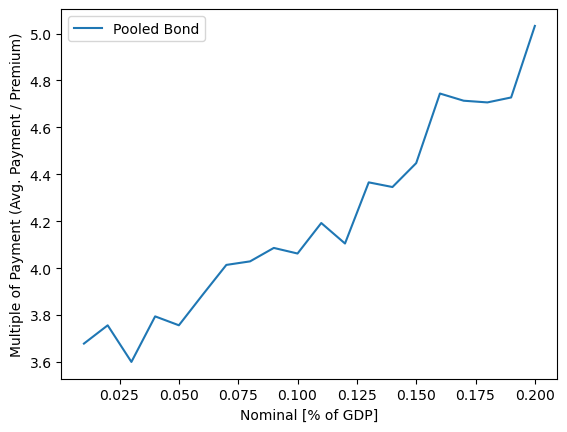

In [16]:
pay_multip  = [e1 / e2 for e1, e2 in zip(avg_pay_prot, abs_prem_pool)]
pay_multip_174  = [e1 / e2 for e1, e2 in zip(avg_pay_abs_174, abs_prem_pool_99_174)]
pay_multip_662  = [e1 / e2 for e1, e2 in zip(avg_pay_abs_662, abs_prem_pool_99_662)]


plt.plot(prot_share_arr, pay_multip, label='Pooled Bond')
plt.xlabel('Nominal [% of GDP]')
plt.ylabel('Multiple of Payment (Avg. Payment / Premium)')
plt.legend()
plt.show()

In [30]:
#save session varibales in database file
dill.dump_session('C:/Users/kaibe/Documents/ETH_Zurich/Thesis/Data/sessions/pooled_bond_lowrf_091724.db')